<div style="text-align:center;font-size:22pt; font-weight:bold;color:white;border:solid black 1.5pt;background-color:#1e7263;">
    Understanding the ReduceLROnPlateau Callback in Keras: Synthetic Data
</div>

In [1]:
# ======================================================================= #
# Course: Deep Learning Complete Course (CS-501)
# Author: Dr. Saad Laouadi
# Institution: Quant Coding Versity Academy
# Date: December 25, 2024
#
# ==========================================================
# Lesson: Learning Rate Adaptation with ReduceLROnPlateau
#         Synthetic Data Example
# ==========================================================
# ## Learning Objectives
# This example will enable you to:
# 1. Create synthetic data for learning rate adaptation
# 2. Implement ReduceLROnPlateau callback
# 3. Monitor learning rate changes during training
# 4. Visualize the impact of learning rate reduction
# 5. Compare training with and without adaptive learning rates
# =======================================================================
#          Copyright © Dr. Saad Laouadi 2024
# =======================================================================

In [2]:
# ==================================================== #
#        Load Required Libraries
# ==================================================== #

import os  
import shutil
from datetime import datetime

# Disable Metal API Validation
os.environ["METAL_DEVICE_WRAPPER_TYPE"] = "0"  


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# import tensorflow
import tensorflow as tf

# Import the ReduceLROnPlateau callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Set styling for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*72)

%reload_ext watermark
%watermark -a "Dr. Saad Laouadi" -u -d -m

print("="*72)
print("Imported Packages and Their Versions:")
print("="*72)

%watermark -iv
print("="*72)

# Global Config
RANDOM_STATE = 101

Author: Dr. Saad Laouadi

Last updated: 2025-01-07

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Imported Packages and Their Versions:
matplotlib: 3.9.2
pandas    : 2.2.2
seaborn   : 0.13.2
keras     : 3.6.0
tensorflow: 2.16.2
sklearn   : 1.5.1
numpy     : 1.26.4



In [3]:
def cleanup_directory(directory_path):
    """
    Deletes the specified directory and all its contents.

    Args:
        directory_path (str): Path to the directory to delete.
    """
    if os.path.exists(directory_path) and os.path.isdir(directory_path):
        shutil.rmtree(directory_path)
        print(f"Directory '{os.path.basename(directory_path)}' deleted successfully.")
    else:
        print(f"Directory '{os.path.basename(directory_path)}' does not exist or is not a directory.")

### The Lecture Raodmap 

1. Utility Code
2. Practical part
   - Generate the data
   - Explore the data
   - Train the model
   - Analyze the results

In [4]:
# A function to create a synthetic data
def create_synthetic_data(n_samples=10000, random_state=0):
    """
    Create a synthetic classification dataset with deliberately challenging features
    to demonstrate learning rate adaptation.
    """
    # Generate a complex classification problem
    X, y = make_classification(
        n_samples=n_samples,
        n_features=20,                       # More features for complexity
        n_informative=15,                    # Most features are informative
        n_redundant=3,                       # Some redundant features
        n_repeated=2,                        # Some repeated features
        n_classes=3,                         # Multi-class problem
        n_clusters_per_class=2,              # Multiple clusters per class
        class_sep=0.8,                       # Moderate class separation
        flip_y=0.1,                          # Add some label noise
        random_state=random_state
    )
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert labels to one-hot encoding
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [5]:
# A function to create deep learning model
def create_model(input_shape, n_classes=3):
    """
    Create a model that's complex enough to benefit from learning rate adaptation
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape= input_shape),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        # Hidden layers
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        # Output layer
        tf.keras.layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [6]:
# Visualization function 
def plot_data_distribution(X_train, y_train):
    """Visualize the synthetic data distribution"""
    plt.figure(figsize=(12, 4))
    
    # Plot first two features
    plt.subplot(1, 2, 1)
    for i in range(3):
        mask = y_train.argmax(axis=1) == i
        plt.scatter(X_train[mask, 0], X_train[mask, 1], 
                   label=f'Class {i}', alpha=0.6)
    plt.title('First Two Features Distribution')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    
    # Plot feature correlations
    plt.subplot(1, 2, 2)
    plt.hist([X_train[:, i] for i in range(5)], 
             label=[f'Feature {i+1}' for i in range(5)],
             bins=30, alpha=0.5)
    plt.title('Feature Distributions')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [7]:
# Function for training the model with ReduceLROnPlateau callback
def train_with_reduce_lr():
    """Train model with ReduceLROnPlateau callback"""
   
    # Generate synthetic data
    X_train, X_test, y_train, y_test = create_synthetic_data()
   
    # Create model
    model = create_model((X_train.shape[1],))
   
    # Define ReduceLROnPlateau callback
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
           monitor='val_loss',
           factor=0.2,          # Reduce LR by 20%
           patience=5,          # Wait 5 epochs before reducing
           min_lr=1e-6,         # Don't reduce LR below this value
           cooldown=2,          # Wait 2 epochs after reduction before monitoring again
           verbose=1            # Print message when reducing LR
       )
   
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[reduce_lr],
        verbose=1
    )
    
    return model, history, X_test, y_test

In [8]:
# A function to detect the learning rate changes
def detect_lr_changes(history):
    """Detect epochs where learning rate changed"""
    # Use 'learning_rate' key directly from history
    lr_values = history.history.get('learning_rate', [])
    epochs_with_changes = []
    
    if lr_values:
        for i in range(1, len(lr_values)):
            # Check if learning rate changed
            if abs(lr_values[i] - lr_values[i-1]) > 1e-10:
                epochs_with_changes.append(i)
                
        # Print info about LR changes
        print(f"\nDetected {len(epochs_with_changes)} learning rate changes:")
        for i, epoch in enumerate(epochs_with_changes):
            old_lr = lr_values[epoch-1]
            new_lr = lr_values[epoch]
            reduction = (old_lr - new_lr) / old_lr * 100
            print(f"Change {i+1} at epoch {epoch}: {old_lr:.2e} → {new_lr:.2e} "
                  f"({reduction:.1f}% reduction)")
    else:
        print("\nNo learning rate values found in history.")
    
    return epochs_with_changes

In [9]:
# Visualization function
def plot_training_curves(history):
    """Plot training curves with learning rate changes"""
    fig = plt.figure(figsize=(15, 8))
    gs = plt.GridSpec(2, 2, height_ratios=[2, 1])

    # Loss subplot
    ax1 = plt.subplot(gs[0, 0])
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    
    # Add vertical lines for LR changes
    lr_changes = detect_lr_changes(history)
    for epoch in lr_changes:
        ax1.axvline(x=epoch, color='r', linestyle='--', alpha=0.3,
                   label='LR Change' if epoch == lr_changes[0] else "")
    
    ax1.set_title('Model Loss with LR Changes')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy subplot
    ax2 = plt.subplot(gs[0, 1])
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    
    # Add same vertical lines
    for epoch in lr_changes:
        ax2.axvline(x=epoch, color='r', linestyle='--', alpha=0.3)
    
    ax2.set_title('Model Accuracy with LR Changes')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Learning rate subplot
    ax3 = plt.subplot(gs[1, :])
    lr_values = history.history.get('learning_rate', [])  # Changed key to 'learning_rate'
    if lr_values:
        ax3.plot(lr_values, 'b-', label='Learning Rate')
        ax3.set_yscale('log')
        ax3.set_title('Learning Rate Changes')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate (log scale)')
        ax3.grid(True)
        ax3.legend()

    plt.tight_layout()
    plt.show()

In [10]:
# Training Analysis
def analyze_training(history, X_test, y_test):
    """Analyze training results"""
    # Get test performance
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Detect learning rate changes
    lr_changes = detect_lr_changes(history)

    print("\nTraining Analysis:")
    print("-" * 50)
    print(f"Training completed in {len(history.history['loss'])} epochs")
    print(f"Number of learning rate changes: {len(lr_changes)}")
    print("\nLearning Rate Changes at epochs:", lr_changes)
    print("\nFinal Performance:")
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Analyze improvement after each LR change
    if lr_changes:
        print("\nImpact of Learning Rate Changes:")
        for epoch in lr_changes:
            before_loss = history.history['val_loss'][epoch-1]
            after_loss = history.history['val_loss'][min(epoch+5, len(history.history['val_loss'])-1)]
            improvement = (before_loss - after_loss) / before_loss * 100
            print(f"Epoch {epoch}: {improvement:.1f}% loss improvement over next 5 epochs")

In [11]:
# ======================================================================= #
#         Practice Part: Step by Step guide to understand 
#                        the ReduceLROnPlateau Callback
# ======================================================================= #
# Step 01: Generate synthetic data
X_train, X_test, y_train, y_test = create_synthetic_data(random_state=RANDOM_STATE)

# Print dataset information

print("*"*72)
print("Dataset Information:".center(72))
print("*"*72)


print(f"{'Training set shape':<25}: {X_train.shape}")
print(f"{'Test set shape':<25}: {X_test.shape}")
print(f"{'Number of classes':<25}: {y_train.shape[1]}")
print(f"{'Number of features':<25}: {X_train.shape[1]}")

print("*"*72)

************************************************************************
                          Dataset Information:                          
************************************************************************
Training set shape       : (8000, 20)
Test set shape           : (2000, 20)
Number of classes        : 3
Number of features       : 20
************************************************************************


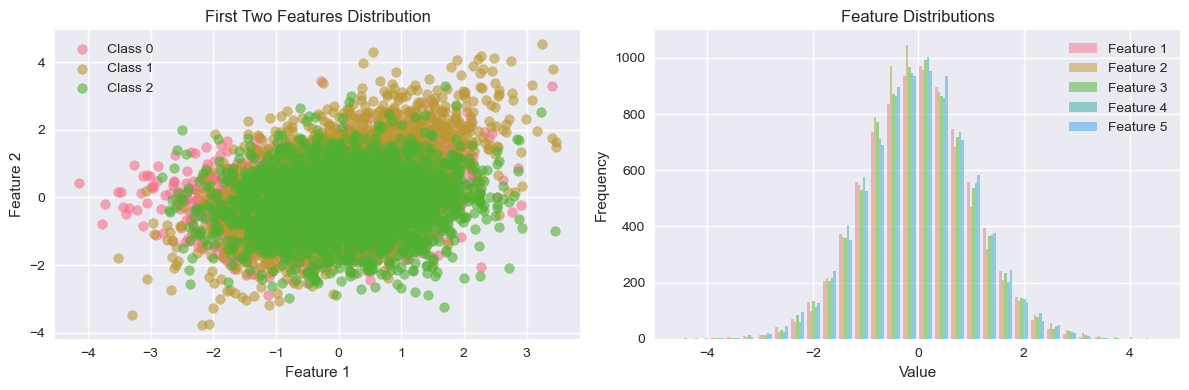

In [12]:
# Visualize data distribution
plot_data_distribution(X_train, y_train)

In [13]:
# Create and display model
model = create_model((X_train.shape[1],))

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,627 (197.76 KB)

 Trainable params: 49,667 (194.01 KB)

 Non-trainable params: 960 (3.75 KB)

None


In [14]:
# Train model with ReduceLROnPlateau
model, history, X_test, y_test = train_with_reduce_lr()

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.4862 - loss: 1.2065 - val_accuracy: 0.6500 - val_loss: 0.8784 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6449 - loss: 0.8301 - val_accuracy: 0.7569 - val_loss: 0.6993 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7105 - loss: 0.7185 - val_accuracy: 0.8000 - val_loss: 0.5736 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7495 - loss: 0.6482 - val_accuracy: 0.8294 - val_loss: 0.5193 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7787 - loss: 0.5943 - val_accuracy: 0.8400 - val_loss: 0.4904 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7861 - loss: 0.6029 - val_accuracy: 0.8419 - val_loss: 0.4829 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8012 - loss: 0.


Detected 1 learning rate changes:
Change 1 at epoch 48: 1.00e-03 → 2.00e-04 (80.0% reduction)


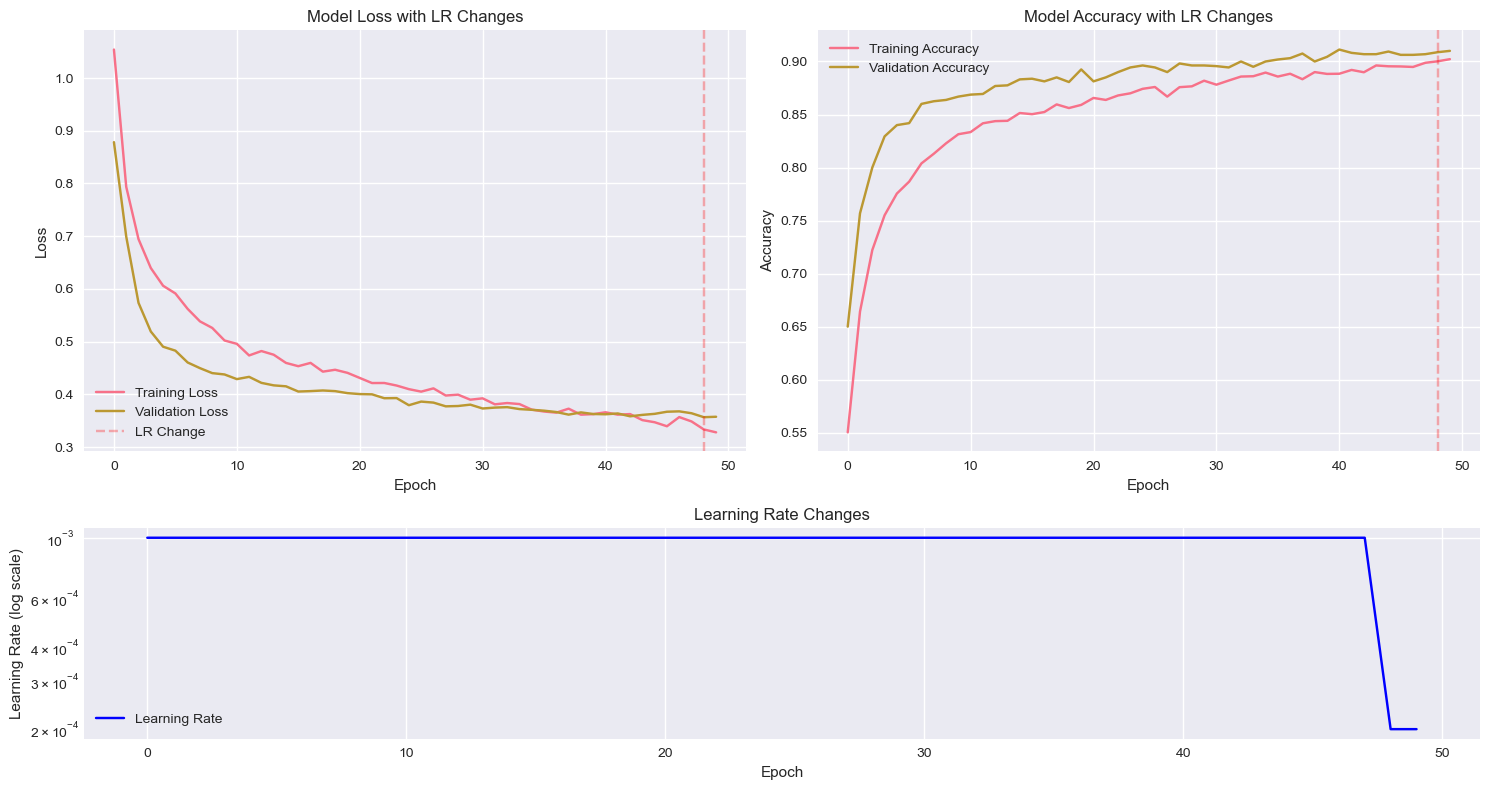

In [15]:
# Plot results of the trained model
plot_training_curves(history)

In [16]:
# Analyze training results
analyze_training(history, X_test, y_test)


Detected 1 learning rate changes:
Change 1 at epoch 48: 1.00e-03 → 2.00e-04 (80.0% reduction)

Training Analysis:
--------------------------------------------------
Training completed in 50 epochs
Number of learning rate changes: 1

Learning Rate Changes at epochs: [48]

Final Performance:
Test loss: 0.3781
Test accuracy: 0.9045

Impact of Learning Rate Changes:
Epoch 48: 1.8% loss improvement over next 5 epochs
